In [99]:
# This notebook will access the spatial autocorrelation of our tree dataset using the Morans-I statistic 

# by Amanda Worthy w reference from: 

#https://geographicdata.science/book/notebooks/07_local_autocorrelation.html

#https://scikit-gstat.readthedocs.io/en/latest/userguide/variogram.html


In [100]:
#import packages
from shapely.geometry import shape
#import rasterstats
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from shapely.geometry.point import Point
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import fiona
import pyproj
import os
import requests
import matplotlib.ticker as ticker
from rasterio.enums import Resampling
from affine import Affine
import shapely.geometry
import pyproj
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import plotly.express as px
import pandas as pd
import rasterio
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
import geopandas as gpd
import rioxarray
from rasterstats import zonal_stats
import contextily 
from pysal.explore import esda  
from pysal.lib import weights  
import seaborn 
from splot import esda as esdaplot
from pysal.viz import splot
from splot.esda import plot_moran
from pysal.lib import weights  



In [101]:
!ls

Modeling_w_spatial_cv.ipynb
Newest_dataset_analysis_python.ipynb
Tree_ds_sep16.csv
environment.yml
explore_variation_among_same_location.ipynb
spatial_auto_tests.ipynb
usa.geojson


In [102]:
#import the USA file 
usa_fxn = "usa.geojson"

usa = gpd.read_file(usa_fxn)

In [103]:
#import the tree dataset 
tree_fxn = "Tree_ds_sep16.csv"

tree= pd.read_csv(tree_fxn)

mygeometry_array = gpd.points_from_xy(tree['Longitude'], tree['Latitude'])

tree= gpd.GeoDataFrame(
tree, crs='EPSG:3857', geometry=mygeometry_array)

tree = tree[~tree['Region'].isin(['California', 'Washington'])]  #okay we are taking it i guess 


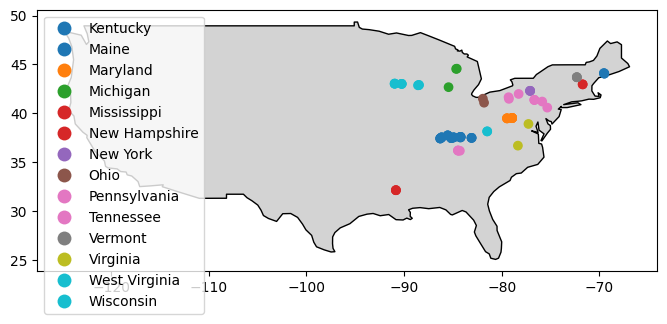

In [104]:
# we encounter a problem where we have duplicate locations
# thus we will not calculate the Moran's I through distance lag weights but use KNN to group 

# lets decide how many groups we want! 

# how many groupings?!?!?

#lets go with 9!

fig, ax = plt.subplots(figsize=(8,6))

usa.plot(ax=ax, color='lightgray', edgecolor='black')
tree.plot(column='Region', legend=True, ax=ax);


In [96]:
# generate weights 
# we can change these with different groupings 
w = weights.distance.KNN.from_dataframe(tree, k=9)

# columns to look @ 
cols = ["d18O", "d2H", "d34S", "d13C"]

results = []

for col in cols:
    moran = esda.moran.Moran(tree[col], w)
    results.append({
        "Variable": col,
        "Moran's I": moran.I,
        "p-value": moran.p_sim
    })

#make in a df 
moran_i_results = pd.DataFrame(results)
moran_i_results

#this means we have spatial auto correlation for oxygen (0.47), hydrogen (0.53), and sulphur (0.46) 
#less for carbon (0.14) 

,Variable,Moran's I,p-value
0,d18O,0.469213,0.001
1,d2H,0.527516,0.001
2,d34S,0.459422,0.001
3,d13C,0.143249,0.004


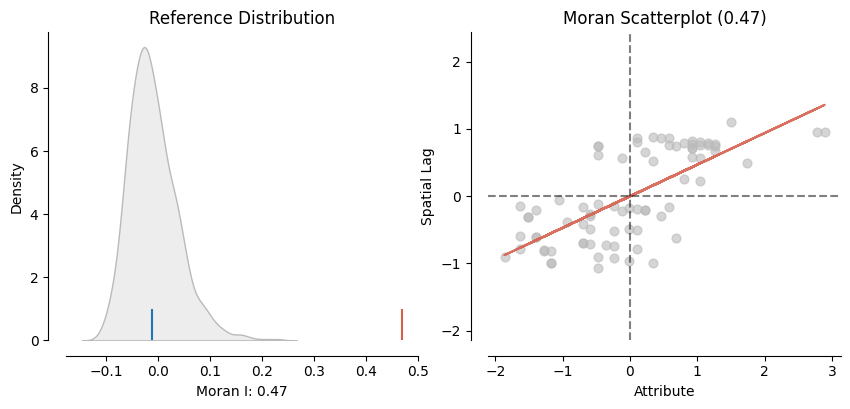

In [81]:
#lets look at just oxygen for now

moran = esda.moran.Moran(tree["d18O"], w)
moran.I

moran.p_sim

#can conclude that the map displays more spatial pattern 
#than we would expect if the values had been randomly allocated to a locations.

plot_moran(moran);

#this means we have spatial correlation for oxygen (0.47), hydrogen (0.52), and sulphur (0.45) 
#less for carbon (0.14) 

In [88]:
#now we look at local spatail acutocorrelation 

tree["w_d18O"] = weights.lag_spatial(w, tree["d18O"])

tree["d18O_std"] = tree["d18O"] - tree["d18O"].mean()
tree["w_d18O_std"] = weights.lag_spatial(w, tree['d18O_std'])



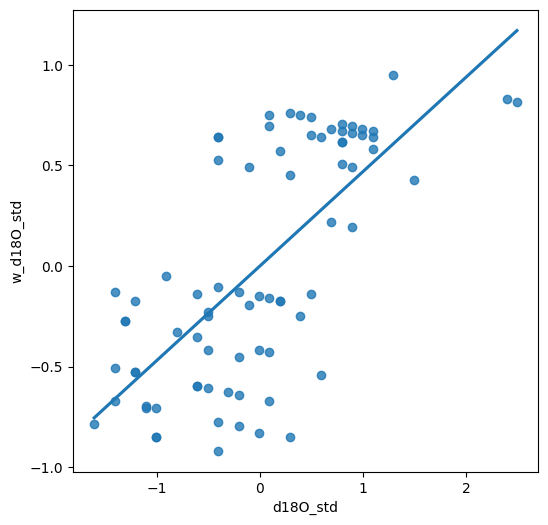

In [89]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="d18O_std", y="w_d18O_std", data=tree, ci=None
)
plt.show()

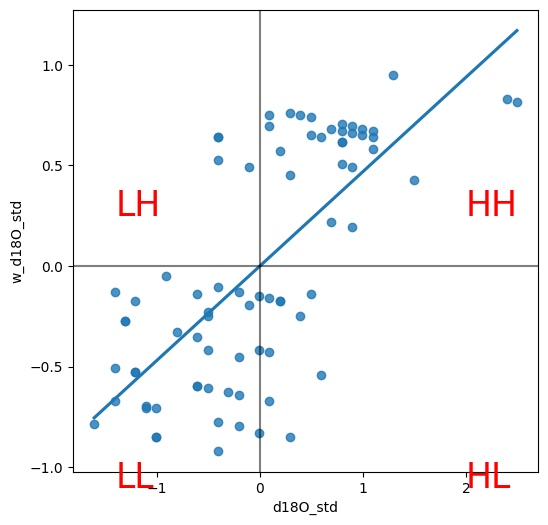

In [90]:
#set up plot of local morans I 

f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="d18O_std", y="w_d18O_std", data=tree, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(2, 0.25, "HH", fontsize=25, c="r")
plt.text(2, -1.1, "HL", fontsize=25, c="r")
plt.text(-1.4, 0.25, "LH", fontsize=25, c="r")
plt.text(-1.4, -1.1, "LL", fontsize=25, c="r")
# Display
plt.show()

In [97]:
lisa = esda.moran.Moran_Local(tree["d18O"], w)

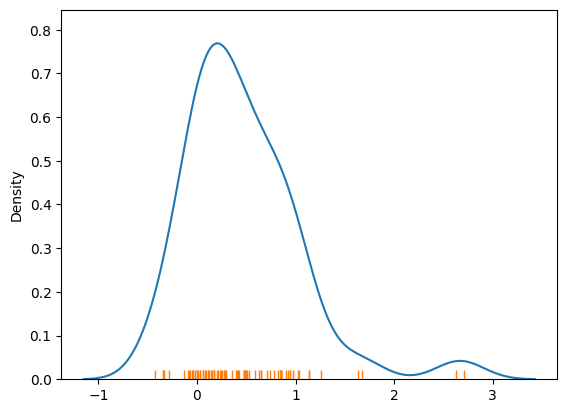

In [98]:
# look at skew of autocorrelation 

# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

<Axes: >

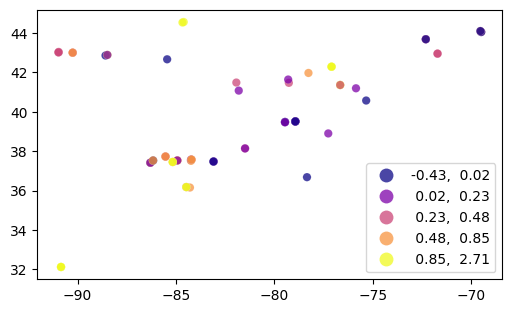

In [93]:
# Set up figure and axes
f, ax = plt.subplots(figsize=(6, 6))
# Make the axes accessible with single indexing

# Choropleth of local statistics

# Assign new column with local statistics on-the-fly
tree.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

some notes: each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (d18O) or its spatial lag (w_d18O_std). We name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right.

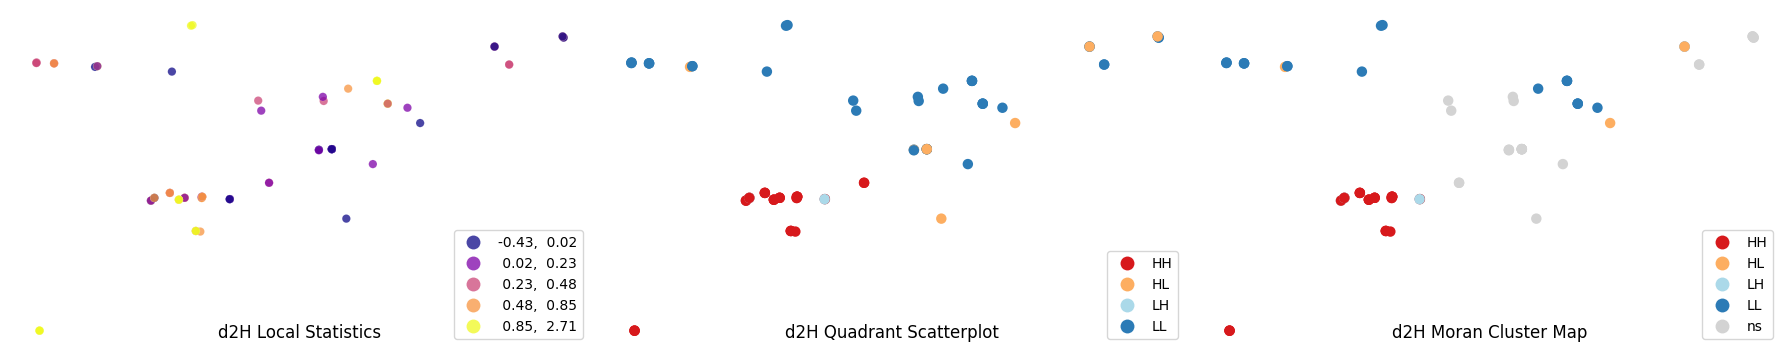

In [94]:
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 
# Choropleth of local statistics
ax = axs[0]
# Assign new column with local statistics on-the-fly
tree.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 
# Quadrant categories
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, tree, p=1, ax=ax)


# Subplot 3 
# Cluster map
ax = axs[2]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, tree, p=0.05, ax=ax)

# Figure styling 
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "d2H Local Statistics",
            "d2H Quadrant Scatterplot ",
            "d2H Moran Cluster Map",
        ][i],
        y=0,
    )

f.tight_layout()

# Display the figure
plt.show()